# Clustering on Diva without division on targets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import category_encoders as ce
from pathlib import Path

np.random.seed(10)

In [38]:
import bz2
import pickle

def save_pickle_bz2(path: str, obj):
    """Saves a pickle file compressed in BZ2 format.

    Args:
        path (str): Path where to save object.
        obj (Any): Object to save.
    """
    with bz2.open(path, "wb") as f:
        pickle.dump(obj, f)
def load_pickle_bz2(path):
    """
    Loads data saved with save_pickle_bz2

    Args:
        path (str): Path where the data are located

    Returns:
        loaded object
    """
    with bz2.BZ2File(path) as f:
        data = pickle.load(f)
    return data

In [2]:
df = pd.read_excel("./processed_diva.xlsx")
df = df.dropna()
df = df.drop_duplicates()

features, target = df.iloc[:,:-1], df.iloc[:,-1]

In [3]:
target = target.map({0.0: 0, 3.0: 1})

In [4]:
numeric = features.select_dtypes('number')

# feature selection

Removing columns with only one value

In [5]:
numeric_copy = numeric.copy()
print("Discarding features with only one value:")
columns_to_keep = []
for col in numeric_copy.columns:
    count = df[col].value_counts().count()
    if count != 1:
        columns_to_keep.append(col)
    else:
        print(f"Discarding {col=}")
numeric_copy = numeric_copy[columns_to_keep]

Discarding features with only one value:
Discarding col='TIPO_CONTROLLO'
Discarding col='RIM_DA_RES_AUT'
Discarding col='RIMB_NON_CONC_AUT'
Discarding col='CREDITO_NON_RIC_AUT'


Removing numeric columns that I think are categorical columns that have been encoded

In [6]:
possibly_categorical = ['TIPO_DICH_ACCERT','COD_CLASSE_VOLUME']
print("Discarding encoded categorical:")
for col in possibly_categorical:
    print(f"Discarding {col=}")
numeric_copy = numeric_copy.drop(possibly_categorical, axis=1)

Discarding encoded categorical:
Discarding col='TIPO_DICH_ACCERT'
Discarding col='COD_CLASSE_VOLUME'


Removing correlated columns

In [7]:
def correlation_matrix(df: pd.DataFrame, figsize=(50,50)):
    """
    A function to calculate and plot
    correlation matrix of a DataFrame.
    """
    # Create the matrix
    matrix = df.corr()
    
    # Create cmap
    cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)
    # Create a mask
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    
    # Make figsize bigger
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot the matrix
    _ = sns.heatmap(matrix, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap, ax=ax)

In [8]:
def identify_correlated(df, threshold):
    """
    A function to identify highly correlated features.
    """
    # Compute correlation matrix with absolute values
    matrix = df.corr().abs()
    
    # Create a boolean mask
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    
    # Subset the matrix
    reduced_matrix = matrix.mask(mask)
    
    # Find cols that meet the threshold
    to_drop = [c for c in reduced_matrix.columns if \
              any(reduced_matrix[c] > threshold)]
    
    return to_drop

In [9]:
to_drop = identify_correlated(numeric_copy, threshold=0.75)
print(f"Dropping {len(to_drop)} columns:")
for c in to_drop:
    print(f"Dropping {c}")

Dropping 33 columns:
Dropping AFFIDABILITA
Dropping IVA_OP_IMPON_DIC
Dropping CREDITI_IVA_DIC
Dropping VOL_AFF_DICH
Dropping VOL_ACC_DEF
Dropping DETR_IVA_DIC
Dropping DETR_IVA_ACC
Dropping MAG_IMP_IRPEF_ACC
Dropping MAG_IMP_RIT_ACC
Dropping IMP_BEN_AMM
Dropping IMP_BENI_ALTRI
Dropping IMP_INTRA_IMPOST
Dropping IMP_IMPOR_IMPON
Dropping IMP_ESPORTAZ
Dropping IMP_OPER_INT
Dropping IMP_CESS_BENI
Dropping IMP_VE_VOLAFF
Dropping IMP_ACQ_NOIMP
Dropping IMP_ACQ_ESENTI
Dropping IMP_ACQ_NODETR
Dropping IMP_OPER
Dropping IMP_IVA_DEB
Dropping IMP_CONSUM_IMPON
Dropping IMP_SOGG_IVA_IMPON
Dropping FLG_PRES_BILANCIO
Dropping IMP_PERD_CONTEC
Dropping IMP_RIM_FINALI
Dropping IMP_IMPST_NETTA
Dropping imp_ricavi_comp_attiv
Dropping imp_tot_pos
Dropping imp_redd_lrd_attiv
Dropping imp_redd_imp_attiv
Dropping VAR_CREDITO


In [10]:
numeric_copy = numeric_copy.drop(to_drop, axis=1)
numeric_copy['Target'] = target

# Scaling the dataset

In [11]:
feat_cols = numeric_copy.columns[:-1]

## Standard Scaling

In [13]:
from sklearn.preprocessing import StandardScaler

In [16]:
df_std = numeric_copy.copy()
standard_scaler = StandardScaler()
df_std[feat_cols] = standard_scaler.fit_transform(df_std[feat_cols])
df_std.head()

,ANN_IMPST,FLG_PRES_ADESIONE,FLG_PRES_RICORSO,PESO,PESO_ADESIONE,SOLVIBILITA,STATO_CONTROLLO,FL_CONDONO,RIMB_NON_CONC,RIMB_NON_CONC_DEF,...,IMP_ECC_PREC_F24,IMP_IMPST_DEBITO,IMP_IMPST_CREDIT,imp_sps_prest_lavoro,imp_tot_neg,VAR_RIMBORSO,VAR_DETRAZIONE,VAR_VOL_AFF_POS,VAR_VOL_AFF_NEG,Target
0,0.525330,1.205881,-0.542534,0.199212,4.058525,0.228899,0.622848,-0.216617,-0.054656,-0.021763,...,0.124370,-0.043217,0.179158,0.098229,-0.13833,-0.073177,0.531387,0.080565,-0.027459,0
1,-0.856356,-0.829269,-0.542534,-0.634054,-0.449675,0.228899,0.493609,-0.216617,-0.054656,-0.021763,...,-0.117234,-0.043217,-0.054288,-0.037581,-0.13833,-0.033024,-0.215376,-0.044752,-0.035756,0
2,-0.165513,-0.829269,-0.542534,-0.634054,-0.449675,0.228899,0.881327,-0.216617,-0.054656,-0.021763,...,0.002622,-0.035326,-0.054288,-0.029966,-0.13833,-0.073177,-0.138035,-0.044641,-0.035756,0
3,-0.165513,-0.829269,-0.542534,-0.109405,-0.449675,1.194882,-1.444980,-0.216617,-0.054656,-0.021763,...,-0.117234,-0.043217,-0.054288,-0.037581,-0.13833,-0.073177,-0.201583,-0.050602,-0.035756,0
4,-0.165513,1.205881,-0.542534,-0.634054,-0.449675,0.228899,0.752088,-0.216617,-0.054656,-0.021763,...,-0.117234,-0.043217,-0.054288,-0.037581,-0.13833,-0.073177,-0.198857,-0.046994,-0.035756,0


## MinMax scaling

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
df_minmax = numeric_copy.copy()
minmax_scaler = MinMaxScaler()
df_minmax[feat_cols] = minmax_scaler.fit_transform(df_minmax[feat_cols])
df_minmax.head()

,ANN_IMPST,FLG_PRES_ADESIONE,FLG_PRES_RICORSO,PESO,PESO_ADESIONE,SOLVIBILITA,STATO_CONTROLLO,FL_CONDONO,RIMB_NON_CONC,RIMB_NON_CONC_DEF,...,IMP_ECC_PREC_F24,IMP_IMPST_DEBITO,IMP_IMPST_CREDIT,imp_sps_prest_lavoro,imp_tot_neg,VAR_RIMBORSO,VAR_DETRAZIONE,VAR_VOL_AFF_POS,VAR_VOL_AFF_NEG,Target
0,0.6,1.0,0.0,0.086873,0.888889,0.6,0.500000,0.0,0.0,0.0,...,0.004715,0.000000,0.002533,0.005010,0.0,0.000000,1.194026e-02,0.002484,0.033235,0
1,0.2,0.0,0.0,0.034749,0.000000,0.6,0.470588,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.003635,0.0,0.000513,1.023279e-07,0.001146,0.033122,0
2,0.4,0.0,0.0,0.034749,0.000000,0.6,0.558824,0.0,0.0,0.0,...,0.002339,0.000083,0.000000,0.003713,0.0,0.000000,1.236735e-03,0.001147,0.033122,0
3,0.4,0.0,0.0,0.067568,0.000000,0.8,0.029412,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.003635,0.0,0.000000,2.206446e-04,0.001084,0.033122,0
4,0.4,1.0,0.0,0.034749,0.000000,0.6,0.529412,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.003635,0.0,0.000000,2.642362e-04,0.001122,0.033122,0


# Clustering

In [19]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
from kneed import KneeLocator

CLUSTERS = [*range(2, 12)]

In [20]:
def print_metrics(X, kmeans):
    """print the metrics of the kmeans model.
    Parameters
    ----------
        X - normalized dataset
        kmeans - model.
    Prints
    ------
        K
        SSE
        Silhouette score
        Separation
    
    """
    print(f'K={len(kmeans.cluster_centers_)}')
    print('\tSSE:\t\t{}'.format(kmeans.inertia_))
    print('\tSilhouette:\t\t{}'.format(metrics.silhouette_score(X, kmeans.labels_)))
    print('\tDaviesBouldin score:\t\t{}'.format(metrics.davies_bouldin_score(X, kmeans.labels_)))

def run_kmeans(X, range_nclusters=CLUSTERS):
    '''runs kmeans for different values of k'''
    inertia, models = [], []
    for k in range_nclusters:
        k_means = KMeans(init='k-means++', n_clusters= k, n_init=20, random_state=123)
        model = k_means.fit(X) #returns fitted estimator
        models.append(model)
        inertia.append(k_means.inertia_)
    return inertia, models

def plot_silouette(data, models):
    """
    models - list of already fit kmeans models
    """
    fig, axs = plt.subplots(ncols=len(models), figsize=(15,5), sharex=True, sharey=True)
    for i,model in enumerate(models):
        nclusters = model.n_clusters
        axs[i].set_xlim([-0.1, 1])
        axs[i].set_ylim([0, len(data) + (nclusters + 1) * 10])
        axs[i].set_title(f"$K={nclusters}$")
        
        clusters = model.predict(data)
        silhouette_avg = silhouette_score(data, clusters)
        
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(data, clusters)
        
        y_lower = 10
        for j in range(nclusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[clusters == j]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(j) / nclusters)
            axs[i].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            axs[i].text(-0.05, y_lower + 0.5 * size_cluster_i, str(j))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples
        
        # The vertical line for average silhouette score of all the values
        axs[i].axvline(x=silhouette_avg, color="red", linestyle="--")

        axs[i].set_yticks([])  # Clear the yaxis labels / ticks
        axs[i].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        
    plt.tight_layout()

## Clustering on standard scaled dataset

In [21]:
wcss_std, models_std = run_kmeans(df_std[feat_cols])

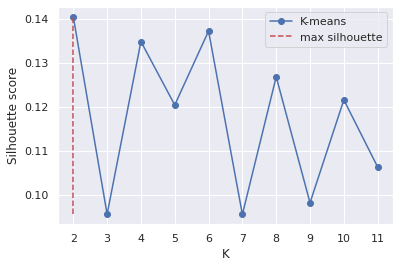

In [22]:
sil_score_std = []
for m in models_std:
    sil_score_std.append(silhouette_score(df_std[feat_cols], m.labels_))
    
plt.plot(CLUSTERS, sil_score_std, 'bo-', label="K-means")
plt.vlines(np.argmax(sil_score_std) + 2, min(sil_score_std), max(sil_score_std), 'r', '--', label="max silhouette")
plt.xticks(CLUSTERS)
plt.xlabel("K")
plt.xticks(range(2, 12))
plt.ylabel("Silhouette score")
plt.legend()
plt.show()

/home/gerardozinno/.pyenv/versions/3.9.9/envs/ml-environment/lib/python3.9/site-packages/kneed/knee_locator.py:304: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

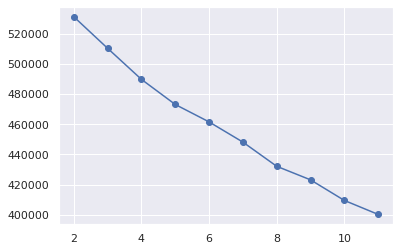

In [23]:
kl = KneeLocator(CLUSTERS, wcss_std, curve="convex", direction="decreasing")
plt.plot(CLUSTERS, wcss_std, 'o-', label="K-means")
plt.vlines(kl.elbow, min(wcss_std), max(wcss_std), 'r', '--', label="elbow")
plt.xticks(CLUSTERS)
plt.xlabel("K")
plt.ylabel("WCSS")
plt.legend()
plt.show()

## Clustering on minmax scaled dataset

In [24]:
wcss_minmax, models_minmax = run_kmeans(df_minmax[feat_cols])

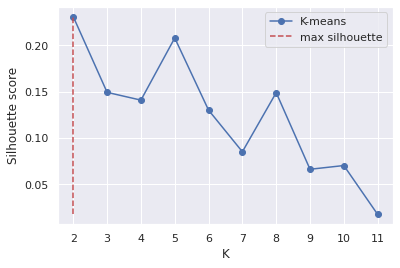

In [26]:
sil_score_minmax = []
for m in models_std:
    sil_score_minmax.append(silhouette_score(df_minmax[feat_cols], m.labels_))
    
plt.plot(CLUSTERS, sil_score_minmax, 'bo-', label="K-means")
plt.vlines(np.argmax(sil_score_minmax) + 2, min(sil_score_minmax), max(sil_score_minmax), 'r', '--', label="max silhouette")
plt.xticks(CLUSTERS)
plt.xlabel("K")
plt.xticks(range(2, 12))
plt.ylabel("Silhouette score")
plt.legend()
plt.show()

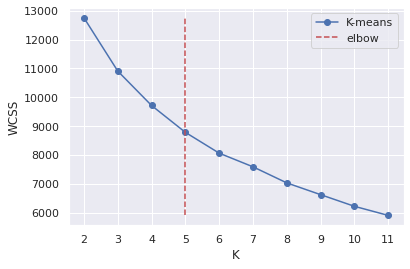

In [27]:
kl = KneeLocator(CLUSTERS, wcss_minmax, curve="convex", direction="decreasing")
plt.plot(CLUSTERS, wcss_minmax, 'o-', label="K-means")
plt.vlines(kl.elbow, min(wcss_minmax), max(wcss_minmax), 'r', '--', label="elbow")
plt.xticks(CLUSTERS)
plt.xlabel("K")
plt.ylabel("WCSS")
plt.legend()
plt.show()

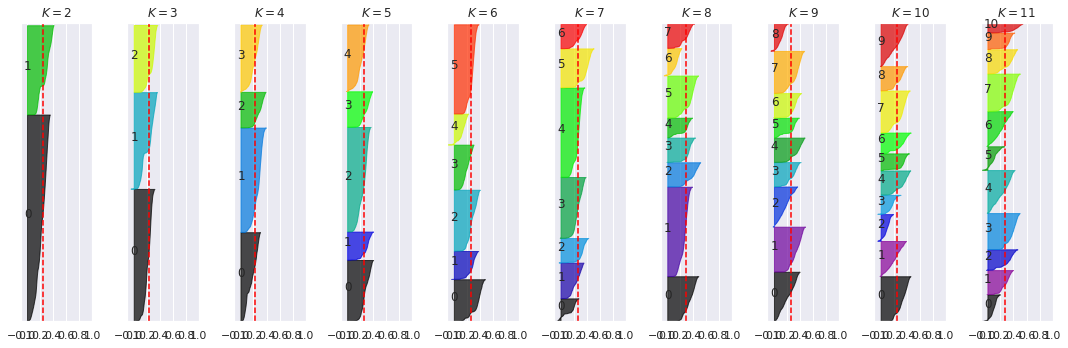

In [29]:
plot_silouette(df_minmax[feat_cols], models_minmax[0:10])

# Picking k=5

In [36]:
selected_kmeans = models_minmax[3]
centroids = selected_kmeans.cluster_centers_

In [34]:
df_minmax['Cluster'] = selected_kmeans.predict(df_minmax[feat_cols])

In [35]:
df_minmax['Cluster'].value_counts()

2    4176
4    2663
0    2444
3    1419
1    1127
Name: Cluster, dtype: int64

## Saving the kmeans model and the centroids

In [37]:
OUTPUTS_PATH = Path("diva_outputs")
OUTPUTS_PATH.mkdir(exist_ok=True)

In [40]:
np.savez(OUTPUTS_PATH / "centroids_minmax_k5", centroids=centroids)
save_pickle_bz2(OUTPUTS_PATH / "kmeans_minmax_k5.bz2", selected_kmeans)

# Test, Training, Validation splitting

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
train_test, validation = train_test_split(df_minmax, train_size=0.8, stratify=df_minmax['Cluster'], random_state=123)
train, test = train_test_split(train_test, train_size=0.7, stratify=train_test['Cluster'], random_state=123)

In [49]:
for s in ["train", "test", "validation"]:
    ss = eval(s)
    print(f"len({s})={len(ss)}")
    print("clusters distribution")
    print(ss['Cluster'].value_counts(normalize=True))

len(train)=6624
clusters distribution
2    0.353110
4    0.225091
0    0.206522
3    0.120018
1    0.095260
Name: Cluster, dtype: float64
len(test)=2839
clusters distribution
2    0.352941
4    0.225079
0    0.206763
3    0.119760
1    0.095456
Name: Cluster, dtype: float64
len(validation)=2366
clusters distribution
2    0.352916
4    0.225275
0    0.206678
3    0.120034
1    0.095097
Name: Cluster, dtype: float64


Generating the set of centroids neighbors

In [60]:
from sklearn.metrics import pairwise_distances

def find_nearest_neighbors(df: pd.DataFrame, centroids, k, columns_to_consider=feat_cols, cluster_col='Cluster', group_by=['Cluster']):
    """
    
    """
    assert len(columns_to_consider) == len(centroids[0])
    # indices of the elements to put in the final dataframe
    clustered_ind = []
    for (_, cluster), cent in zip(df.groupby(group_by), centroids):
        #print(cluster[cluster_col].value_counts())
        #print(f"Centroid: {cent}")
        features = cluster[columns_to_consider].copy()
        distances = pairwise_distances(features, [cent])
        features['Dist'] = distances
        # sort by distance and get the first k rows
        sorted_f = features.sort_values(by=['Dist']).head(k)
        clustered_ind += sorted_f.index.to_list()
    return df.loc[clustered_ind]

In [61]:
centroids_neighbors = find_nearest_neighbors(test, centroids, 8)

# Saving the sets

In [50]:
df_minmax.to_csv(OUTPUTS_PATH / "diva_minmax.csv")
train.to_csv(OUTPUTS_PATH / "diva_train.csv")
test.to_csv(OUTPUTS_PATH / "diva_test.csv")
validation.to_csv(OUTPUTS_PATH / "diva_validation.csv")
centroids_neighbors.to_csv(OUTPUTS_PATH / "diva_centroids_neighbors.csv")

# Creating a random forest

In [73]:
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

In [74]:
# Hyperparameters of the grid search
__HYPERPARAMETERS = {
    "bootstrap": [True, False],
    "max_depth": [100, 350, 500],
    "max_features": ["auto", "sqrt"],
    "min_samples_leaf": [10, 20, 50],
    "min_samples_split": [5, 10, 50],
    "n_estimators": [100, 150, 350, 500],
    "criterion": ["gini", "entropy"],
}

def create_random_forest(
        x,
        y,
        hyperparameters=__HYPERPARAMETERS,
        n_jobs=12
) -> RandomForestClassifier:
    """Creates a random forest classifier via grid search.

    Args:
        x (ndarray): Training input examples.
        y (ndarray): Training target values.
        hyperparameters (Dict[str, List[Any]], optional): Dictionary of hyperparameters for the grid search. Defaults to the fixed ones.
        n_jobs: Number of jobs to run in parallel in the grid search. (default 4)

    Returns:
        RandomForestClassifier: Random forest classifier.
    """

    rf = RandomForestClassifier()
    clf = HalvingGridSearchCV(rf, hyperparameters, refit=True, n_jobs=n_jobs, verbose=1)
    clf.fit(x, y)
    return clf.best_estimator_

## Loading the sets

In [69]:
trainset = pd.read_csv(OUTPUTS_PATH / "diva_train.csv")
testset  = pd.read_csv(OUTPUTS_PATH / "diva_test.csv")
cluster_neighbors = pd.read_csv(OUTPUTS_PATH / "diva_centroids_neighbors.csv")

In [78]:
X_train = trainset[feat_cols].to_numpy()
y_train = trainset['Target'].to_numpy()

X_test = testset[feat_cols].to_numpy()
y_test = testset['Target'].to_numpy()

x_test_clustered = cluster_neighbors[feat_cols].to_numpy()
y_test_clustered = cluster_neighbors['Target'].to_numpy()

In [79]:
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)
assert len(x_test_clustered) == len(y_test_clustered)

In [80]:
rf = create_random_forest(X_train, y_train)

n_iterations: 6
n_required_iterations: 7
n_possible_iterations: 6
min_resources_: 20
max_resources_: 6624
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 864
n_resources: 20
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
----------
iter: 1
n_candidates: 288
n_resources: 60
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
----------
iter: 2
n_candidates: 96
n_resources: 180
Fitting 5 folds for each of 96 candidates, totalling 480 fits
----------
iter: 3
n_candidates: 32
n_resources: 540
Fitting 5 folds for each of 32 candidates, totalling 160 fits
----------
iter: 4
n_candidates: 11
n_resources: 1620
Fitting 5 folds for each of 11 candidates, totalling 55 fits
----------
iter: 5
n_candidates: 4
n_resources: 4860
Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [81]:
from sklearn.metrics import classification_report

print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      2076
           1       0.84      0.67      0.75       763

    accuracy                           0.88      2839
   macro avg       0.86      0.81      0.83      2839
weighted avg       0.87      0.88      0.87      2839



In [82]:
save_pickle_bz2(OUTPUTS_PATH / "diva_minmax_randfor_k5.bz2", rf)
np.savez(OUTPUTS_PATH / "diva_minmax_randfor_data", X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, x_test_clustered=x_test_clustered, y_test_clustered=y_test_clustered)